In [94]:
# Imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import inflection
import datetime
from scipy import stats
from sklearn import preprocessing as pp
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [95]:
# Dataset Loading

df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

df_raw = pd.merge (df_sales_raw, df_store_raw, how='left', on='Store')


In [96]:
# Descrição dos dados

df1 = df_raw.copy()

# Column Renaming

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Id', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

In [97]:
# Data Dimensions

print("Number of Rows: ", df1.shape[0])
print("Number of Columns: ", df1.shape[1])

Number of Rows:  1001599
Number of Columns:  19


In [98]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
id                                int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [99]:
# Data Types
df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%d', errors='raise')


In [100]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
id                                   0
store_type                           0
assortment                           0
competition_distance              2600
competition_open_since_month    318392
competition_open_since_year     318392
promo2                               0
promo2_since_week               500415
promo2_since_year               500415
promo_interval                  500415
dtype: int64

In [101]:
 ## 1.5. Fillout NA
             
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )




C:\Users\igormagro\AppData\Local\Temp\ipykernel_15212\888525431.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['promo_interval'].fillna(0, inplace=True )


In [102]:
## 1.6. Change Data Types
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        

In [103]:
## 1.7. Descriptive Statistics

num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

C:\Users\igormagro\AppData\Local\Temp\ipykernel_15212\140248015.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df1['competition_distance'], kde=False )


<Axes: xlabel='competition_distance'>

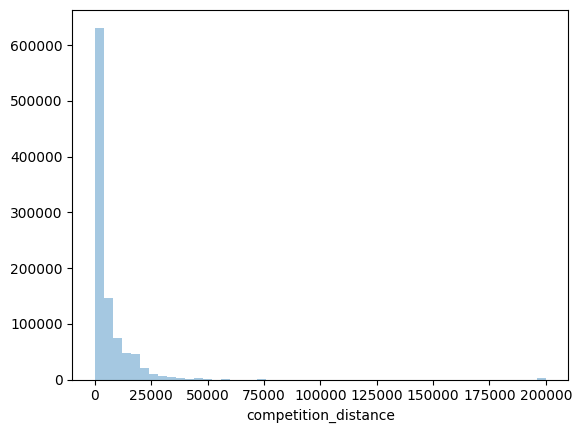

In [104]:
## 1.7.1. Numerical Atributes

# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T
# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
sns.distplot( df1['competition_distance'], kde=False )

<Axes: xlabel='assortment', ylabel='sales'>

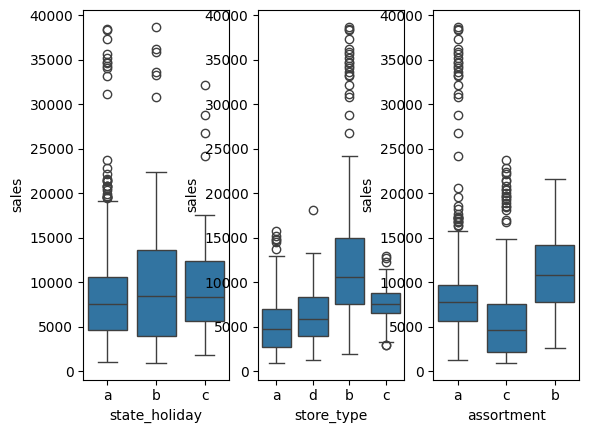

In [105]:
## 1.7.2. Categorical Atributes

cat_attributes.apply( lambda x: x.unique().shape[0] )
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )
plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )
plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )



In [106]:
df2 = df1.copy()    
# Feature Engineering

# year
df2['year'] = df2['date'].dt.year

        # month
df2['month'] = df2['date'].dt.month

        # day
df2['day'] = df2['date'].dt.day

        # week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
        # year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [107]:
##3.2 2.2. Criacao das Hipoteses
#3.2.1 2.2.1. Hipoteses Loja
#1. Lojas com número maior de funcionários deveriam vender mais.
#2. Lojas com maior capacidade de estoque deveriam vender mais.
#3. Lojas com maior porte deveriam vender mais.
#4. Lojas com maior sortimentos deveriam vender mais.
#5. Lojas com competidores mais próximos deveriam vender menos.
#6. Lojas com competidores à mais tempo deveriam vendem mais.
#3.2.2 2.2.2. Hipoteses Produto
#1. Lojas que investem mais em Marketing deveriam vender mais.
#2. Lojas com maior exposição de produto deveriam vender mais.
#3. Lojas com produtos com preço menor deveriam vender mais.
#5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
#6. Lojas com promoções ativas por mais tempo deveriam vender mais.
#7. Lojas com mais dias de promoção deveriam vender mais.
#8. Lojas com mais promoções consecutivas deveriam vender mais.
#3.2.3 2.2.3. Hipoteses Tempo
#1. Lojas abertas durante o feriado de Natal deveriam vender mais.
#2. Lojas deveriam vender mais ao longo dos anos.
#3. Lojas deveriam vender mais no segundo semestre do ano.
#4. Lojas deveriam vender mais depois do dia 10 de cada mês.
#5. Lojas deveriam vender menos aos finais de semana.
#6. Lojas deveriam vender menos durante os feriados escolares.
#3.3 2.3. Lista Final de Hipóteses
#1. Lojas com maior sortimentos deveriam vender mais.
#2. Lojas com competidores mais próximos deveriam vender menos.
#3. Lojas com competidores à mais tempo deveriam vendem mais.
#4. Lojas com promoções ativas por mais tempo deveriam vender mais.
#5. Lojas com mais dias de promoção deveriam vender mais.
#7. Lojas com mais promoções consecutivas deveriam vender mais.
#8. Lojas abertas durante o feriado de Natal deveriam vender mais.
#9. Lojas deveriam vender mais ao longo dos anos.
#10. Lojas deveriam vender mais no segundo semestre do ano.
#11. Lojas deveriam vender mais depois do dia 10 de cada mês.
#12. Lojas deveriam vender menos aos finais de semana.
#13. Lojas deveriam vender menos durante os feriados escolares.


In [108]:
df2 = df2[(df2['open'] == 1) & (df2['state_holiday'] != 'regular_day')]

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df2 = df2.drop( cols_drop, axis=1 )


<Axes: xlabel='year_week'>

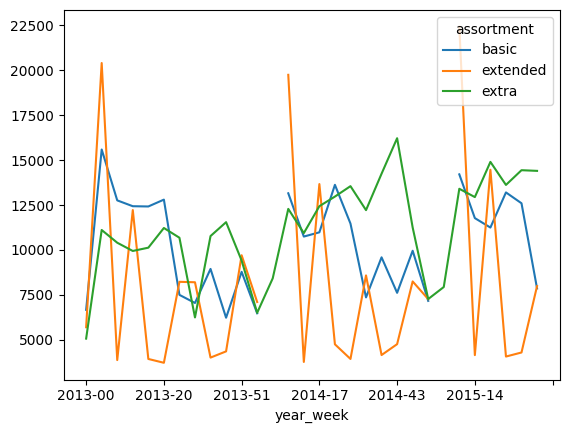

In [109]:
df3 = df2.copy()
### Exploratory Data Analysis (EDA)
## Lojas com maior assortment deve vender mais
aux1 = df3[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
aux2 = df3[['assortment', 'sales', 'year_week']].groupby([ 'assortment' , 'year_week']).mean().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot()



C:\Users\igormagro\AppData\Local\Temp\ipykernel_15212\4180587741.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()


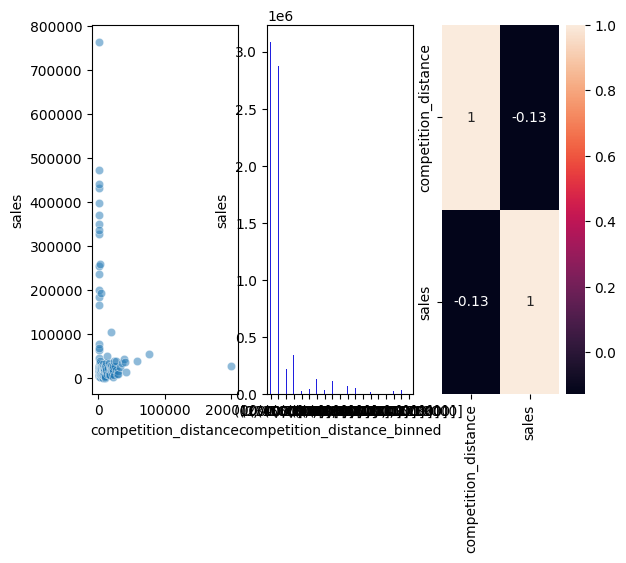

In [110]:
## Lojas com competidoress mais proximos devem vender menos
aux1 = df3[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1, alpha=0.5);
plt.subplot(1, 3, 2)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2, width=0.1, color='blue');


plt.subplot(1, 3, 3)
numeric_cols = aux1.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_cols.corr(method='pearson'), annot=True);



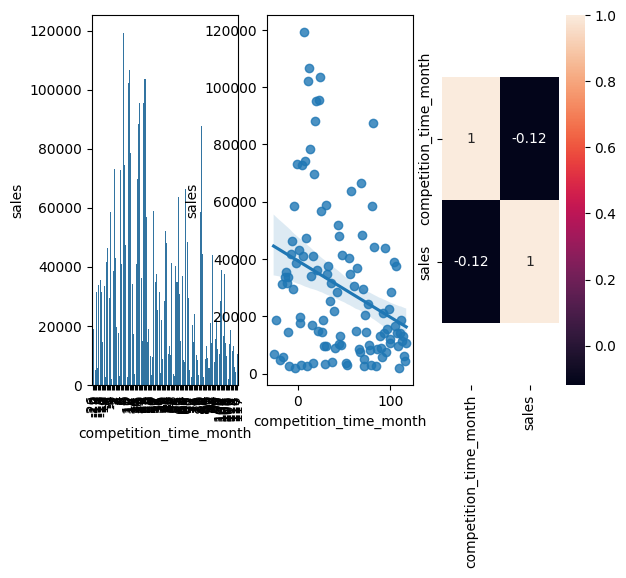

In [111]:
## Lojas com comeptidores mais antigos devem vender mais
plt.subplot( 1, 3, 1 )
aux1 = df3[['competition_time_month', 'sales']].groupby('competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (
aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );
plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

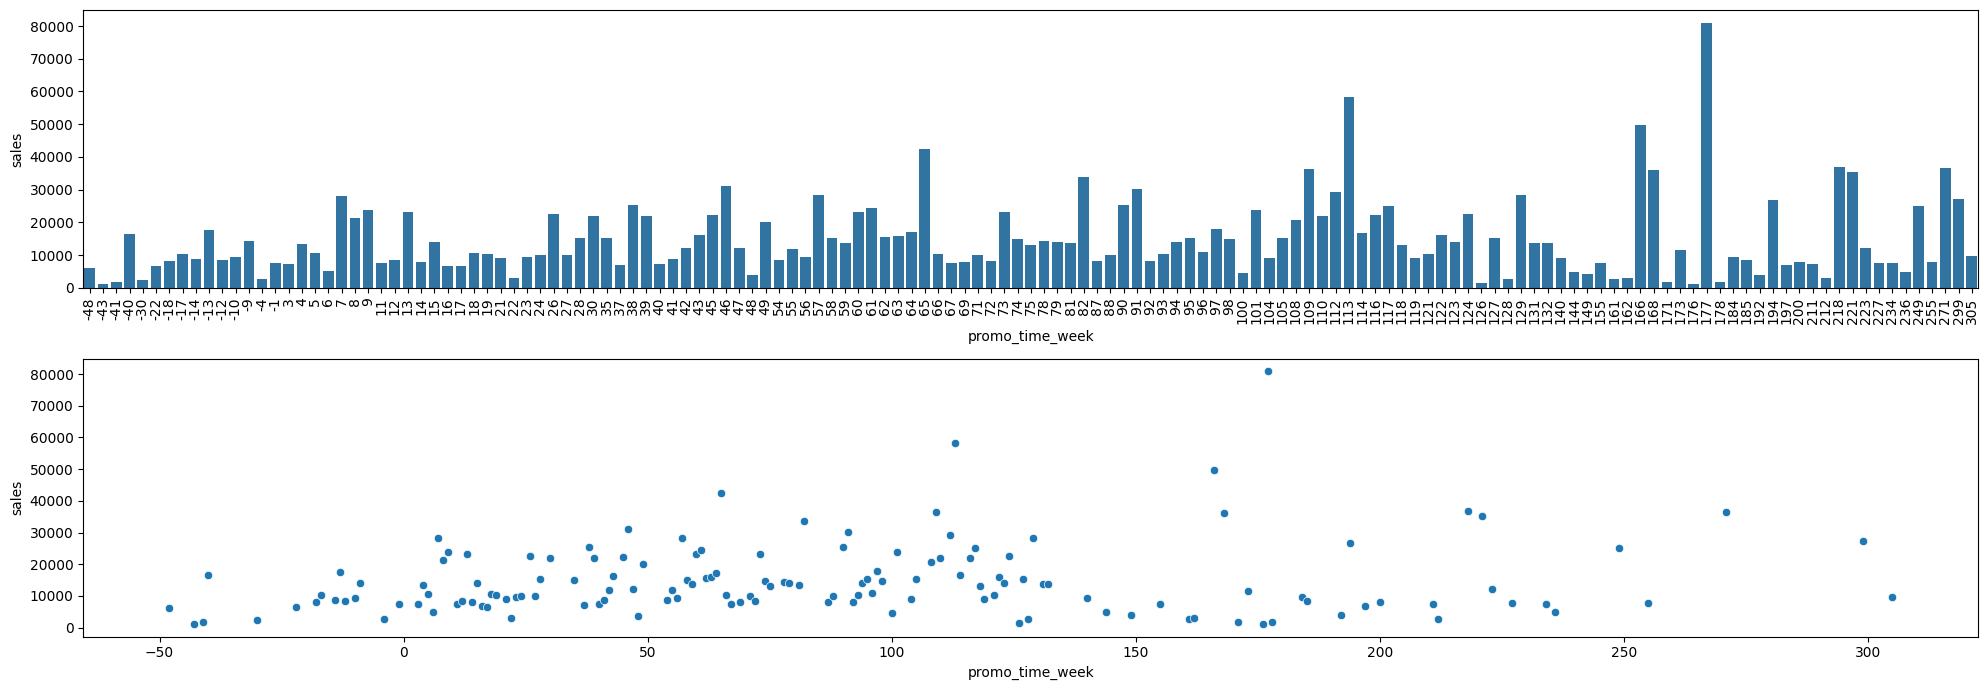

In [112]:
#4. Lojas com promoções ativas por mais tempo deveriam vender mais.
aux1 = df3[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
aux2 = aux1[(aux1['promo_time_week'] != 0)]
plt.figure(figsize=(20, 7))  # Largura de 20 e altura de 5
plt.subplot(2, 1, 1)
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);
plt.subplot(2, 1, 2)
sns.scatterplot(x='promo_time_week', y='sales', data=aux2);

plt.tight_layout()  # Ajusta automaticamente os espaços entre os gráficos
plt.show()

In [113]:
df3.dtypes
#Loja aberta em feriado de Natal deve vender mais
aux1 = filtered[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

#falso


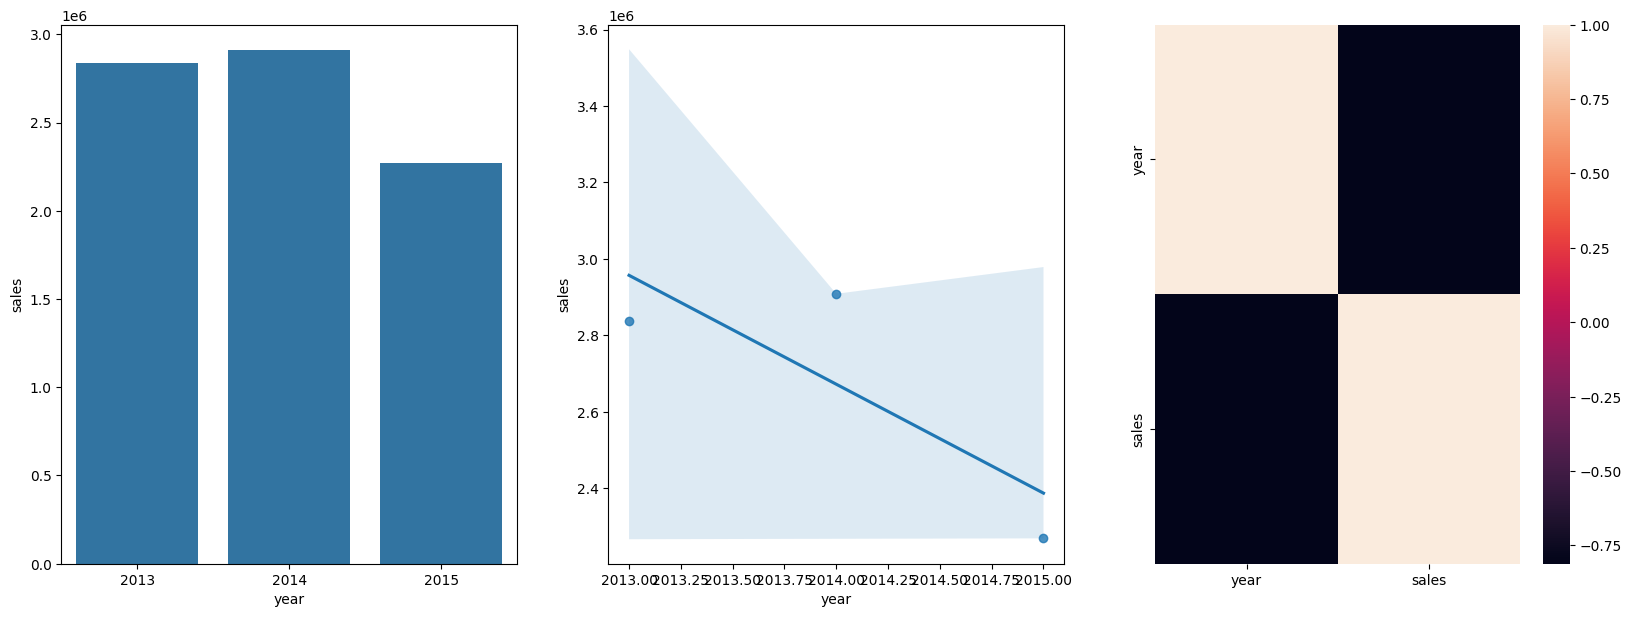

In [114]:
#9. Lojas deveriam vender mais ao longo dos anos.
aux1 = df3[['year', 'sales']].groupby('year').sum().reset_index()
plt.figure(figsize=(20, 7))  # Largura de 20 e altura de 5

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);
plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'));

#Falso

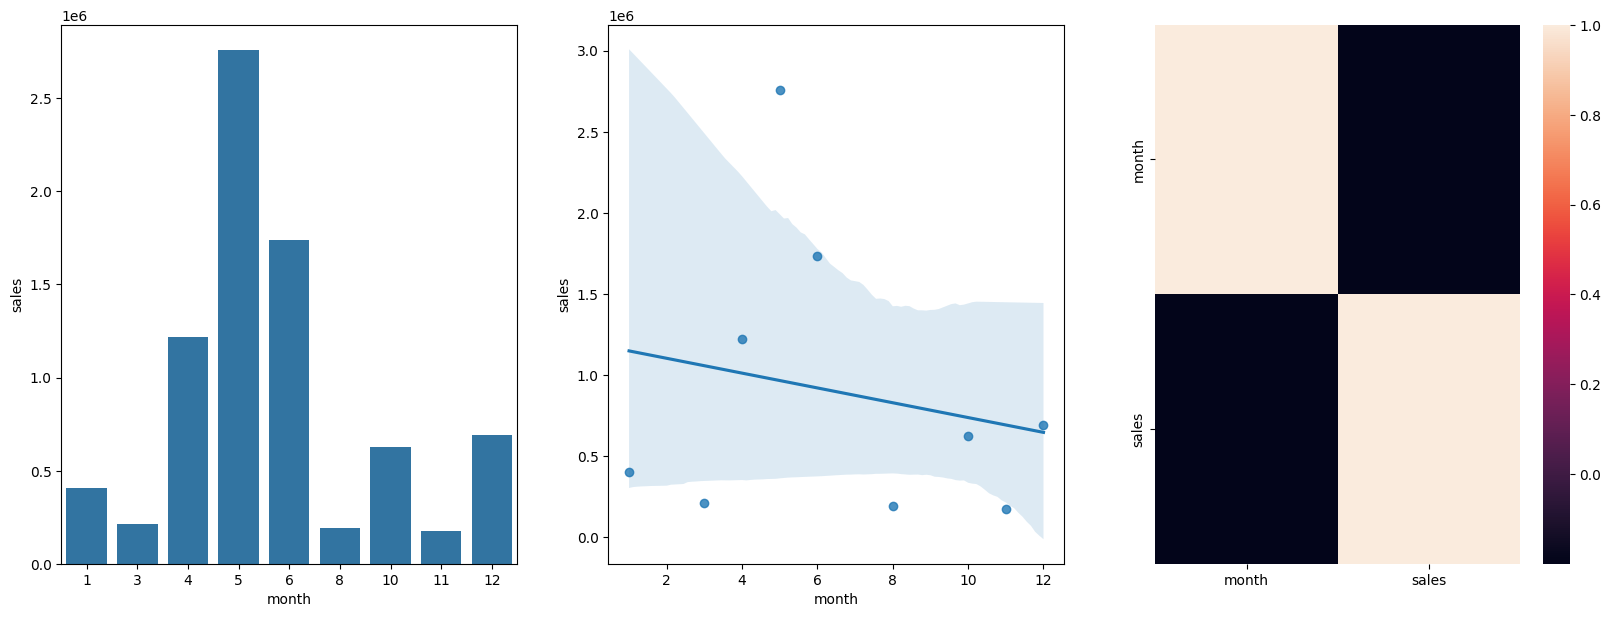

In [115]:
# Lojas deveriam vender mais no segundo semestre do ano.
aux1 = df3[['month', 'sales']].groupby('month').sum().reset_index()
plt.figure(figsize=(20, 7))  # Largura de 20 e altura de 5

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);
plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'));



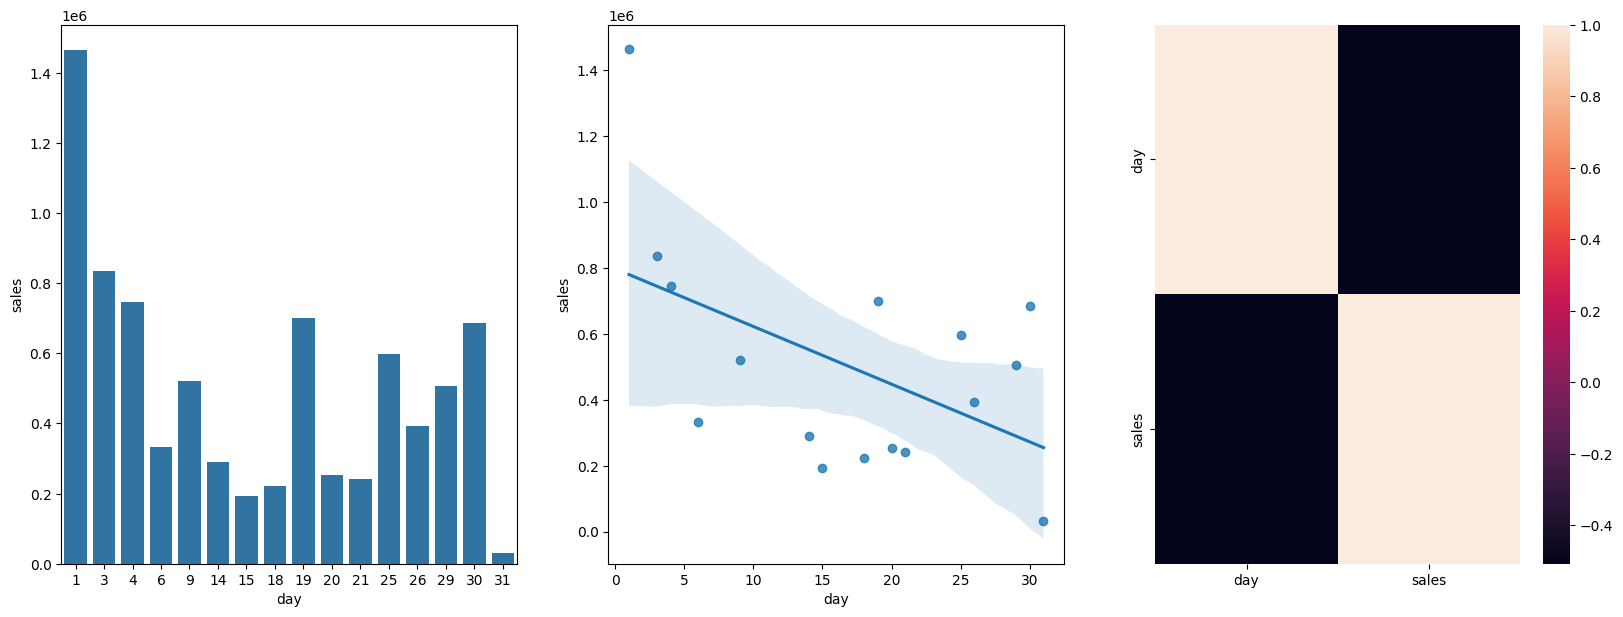

In [116]:
#11. Lojas deveriam vender mais depois do dia 10 de cada mês.
aux1 = df3[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(20, 7))  # Largura de 20 e altura de 5
plt.subplot(1, 3, 1)
sns.barplot(x='day', y='sales', data=aux1);
plt.subplot(1, 3, 2)
sns.regplot(x='day', y='sales', data=aux1);
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'));

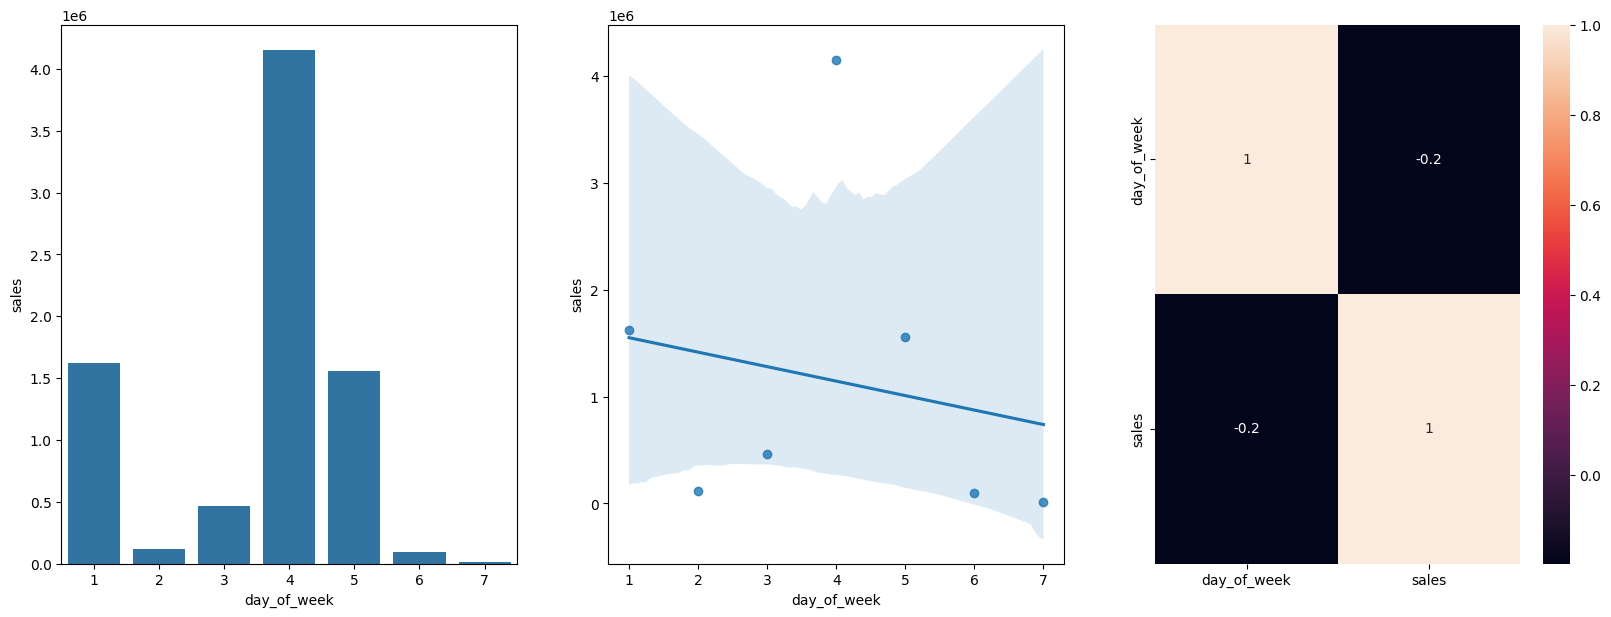

In [117]:
## Lojas deveriam vender menos aos finais de semana.
aux1 = df3[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
plt.figure(figsize=(20, 7))  # Largura de 20 e altura de 5
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);
plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

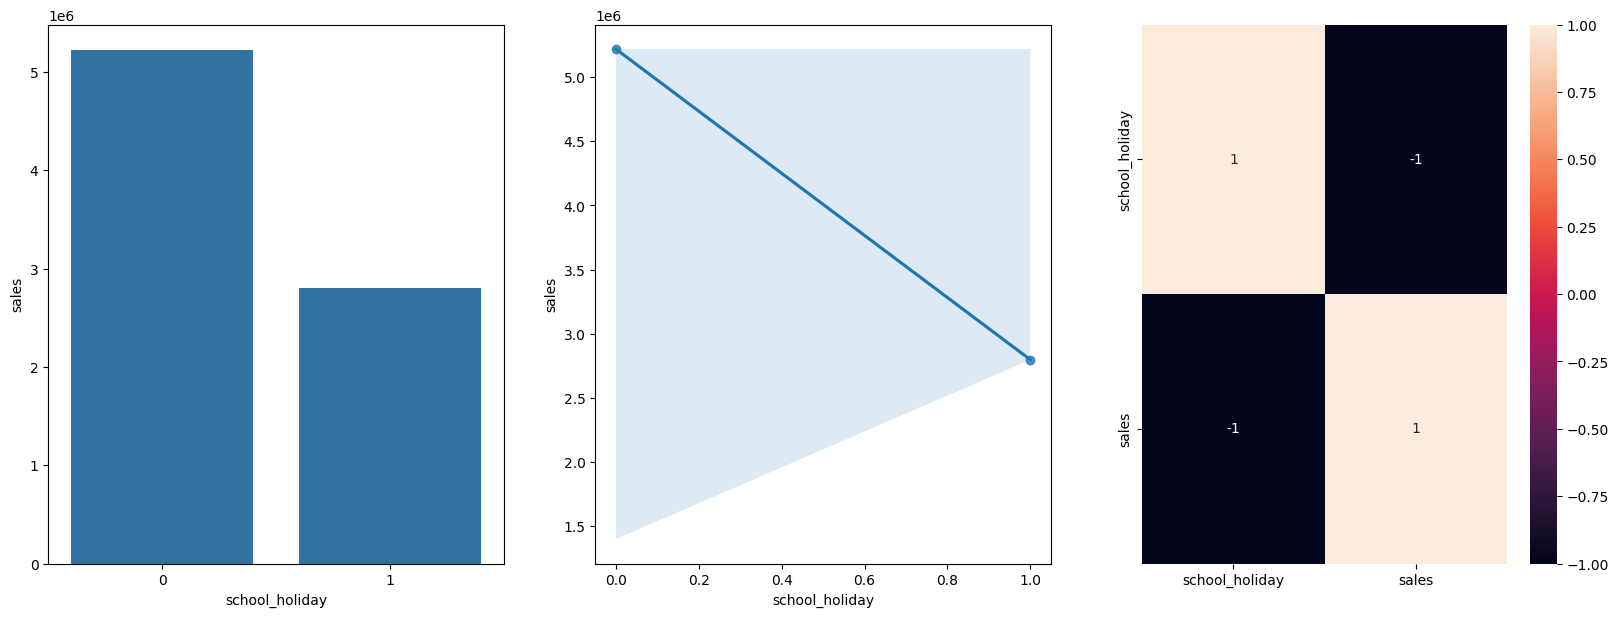

In [118]:
## Lojas deveriam vender mais durante os feriados escolares.
aux1 = df3[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.figure(figsize=(20, 7))  # Largura de 20 e altura de 5
plt.subplot(1, 3, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);
plt.subplot(1, 3, 2)
sns.regplot(x='school_holiday', y='sales', data=aux1);
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

<Axes: >

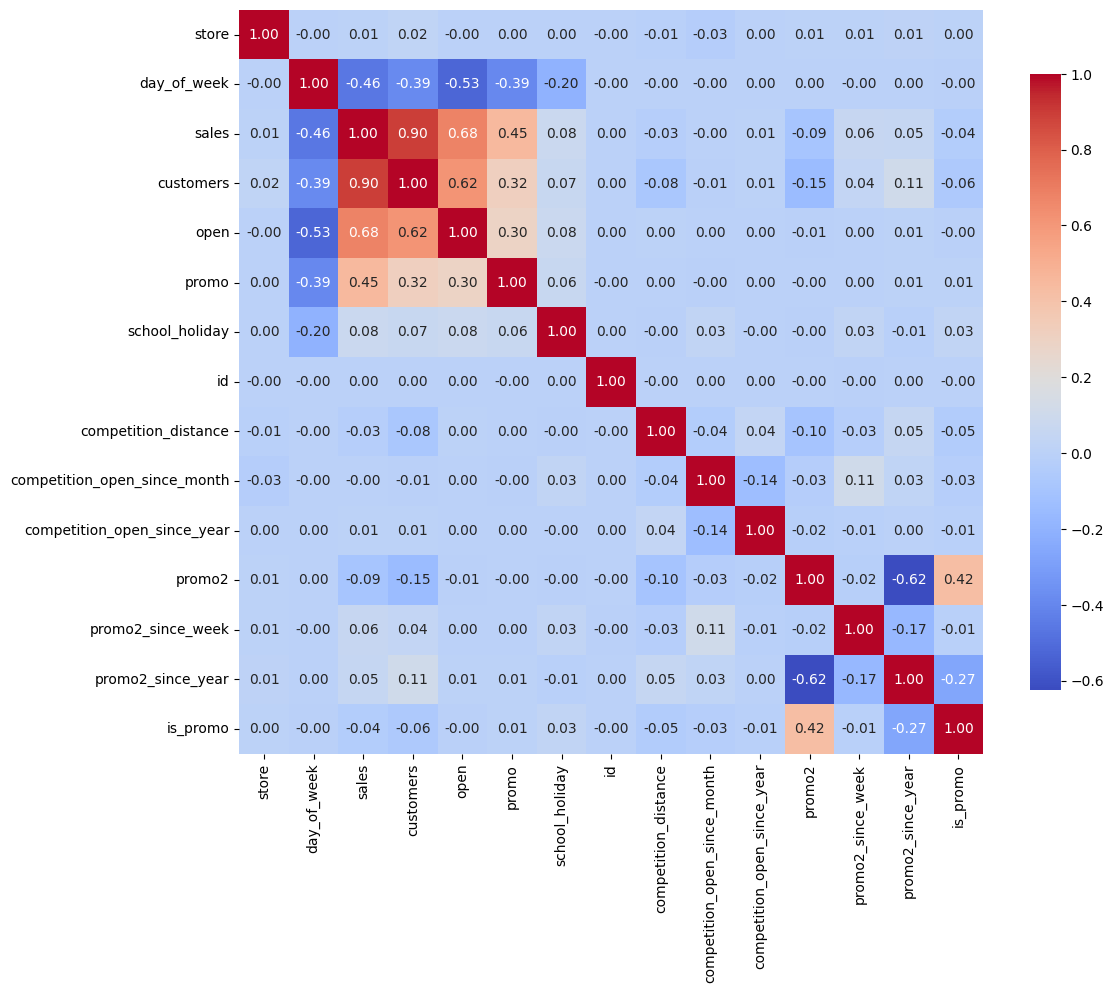

In [119]:
## Analise multivariada
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

<Axes: >

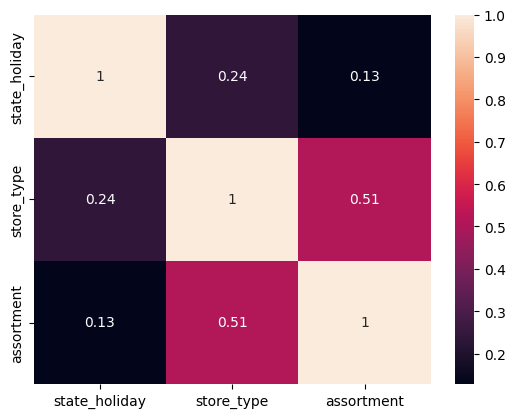

In [120]:
a = df3.select_dtypes( include='object' )
# Calculate cramer V
def cramer_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))



a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )
# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
'store_type': [a4, a5, a6],
'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

### Preparacao dos Dados para Modelagem
df4 = df3.copy()


C:\Users\igormagro\AppData\Local\Temp\ipykernel_15212\1651754740.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['competition_distance'], kde=False)


<Axes: xlabel='competition_distance'>

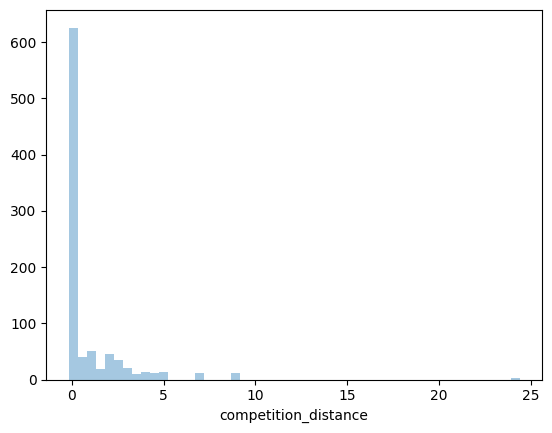

In [121]:
## Rescaling
df4 = df3.copy()
a = df4.select_dtypes( include=['int64', 'float64'] )

rscaler = pp.RobustScaler()
mmscaler = pp.MinMaxScaler()
df4['competition_distance'] = rscaler.fit_transform( df4['competition_distance'].values.reshape(-1, 1) )
df4['competition_time_month'] = rscaler.fit_transform( df4['competition_time_month'].values.reshape(-1, 1) )
df4['promo_time_week'] = mmscaler.fit_transform( df4['promo_time_week'].values.reshape(-1, 1) )
df4['year'] = rscaler.fit_transform( df4['year'].values.reshape(-1, 1) )
sns.distplot(df4['competition_distance'], kde=False)



In [122]:
## Encoding das variáveis categóricas
# One Hot Encoding
df4 = pd.get_dummies(df4, columns=['state_holiday'], prefix=[ 'state_holiday'])
# Label Encoding
le = pp.LabelEncoder()
df4['store_type'] = le.fit_transform(df4['store_type'])
# Ordinal Encoding
assortment_map = {'basic': 1, 'extra': 2, 'extended': 3}
df4['assortment'] = df4['assortment'].map(assortment_map)


<Axes: xlabel='sales', ylabel='Count'>

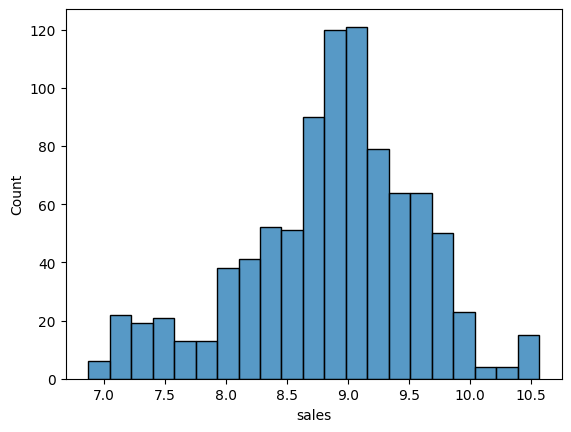

In [123]:
## Transformação de Rensponse Variables
df4['sales'] = np.log1p(df4['sales'])
sns.histplot(df4['sales'])

In [124]:
# Nature transformation
# Month
df4['month_sin'] = df4['month'].apply( lambda x : np.sin (x * (2 * np.pi / 12)) )
df4['month_cos'] = df4['month'].apply( lambda x : np.cos (x * (2 * np.pi / 12)) )
# Day
df4['day_sin'] = df4['day'].apply( lambda x : np.sin (x * (2 * np.pi / 30)) )
df4['day_cos'] = df4['day'].apply( lambda x : np.cos (x * (2 * np.pi / 30)) )
# Week of Year
df4['week_of_year_sin'] = df4['week_of_year'].apply( lambda x : np.sin (x * (2 * np.pi / 52)) )
df4['week_of_year_cos'] = df4['week_of_year'].apply( lambda x : np.cos (x * (2 * np.pi / 52)) )
# Day of week
df4['day_of_week_sin'] = df4['day_of_week'].apply( lambda x : np.sin (x * (2 * np.pi / 7)) )
df4['day_of_week_cos'] = df4['day_of_week'].apply( lambda x : np.cos (x * (2 * np.pi / 7)) )
df4.head()

,store,day_of_week,date,sales,promo,school_holiday,id,store_type,assortment,competition_distance,...,state_holiday_easter_holiday,state_holiday_public_holiday,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
47949,5,4,2015-06-04,8.666992,1,0,45579,0,1,3.498771,...,False,True,1.224647e-16,-1.0,0.743145,0.669131,0.354605,-0.935016,-0.433884,-0.900969
47950,6,4,2015-06-04,8.656955,1,0,101059,0,1,-0.137592,...,False,True,1.224647e-16,-1.0,0.743145,0.669131,0.354605,-0.935016,-0.433884,-0.900969
47999,55,4,2015-06-04,8.697012,1,0,246440,0,1,-0.087224,...,False,True,1.224647e-16,-1.0,0.743145,0.669131,0.354605,-0.935016,-0.433884,-0.900969
48001,57,4,2015-06-04,9.137985,1,0,595815,3,3,-0.124079,...,False,True,1.224647e-16,-1.0,0.743145,0.669131,0.354605,-0.935016,-0.433884,-0.900969
48004,60,4,2015-06-04,9.249561,1,0,272172,3,3,0.504914,...,False,True,1.224647e-16,-1.0,0.743145,0.669131,0.354605,-0.935016,-0.433884,-0.900969


In [125]:
### Feature Selection
df5 = df4.copy()
## Boruta Feature Selection
cols_drop = ['week_of_year', 'day_of_week', 'day', 'month', 'year_week', 'promo_since', 'competition_since']
df5 = df5.drop(columns=cols_drop, axis=1)
df5[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=42)
x_train = df5[df5['date'] < '2015-06-05']
y_train = x_train['sales']
x_test = df5[df5['date'] >= '2015-06-05']
y_test = x_test['sales']

x_train_n = x_train.drop(columns=['sales', 'date'], axis=1).values
y_train_n = y_train.values.ravel()





rf = RandomForestRegressor(n_jobs=1)

boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	13
Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	13
Iteration: 	10 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	13
Iteration: 	11 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	13
Iteration: 	12 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	13
Iteration: 	13 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	13
Iteration: 	14 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	13
Iteration: 	15 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	13
Iteration: 	16 / 100
Confirmed: 	12
Tentative: 	2
Reject

In [131]:
#Colunas selecionadas pelo Boruta

cols_selected = boruta.support_.tolist()


x_train_fs = x_train.drop(columns=['sales', 'date'], axis=1)

cols_boruta = x_train_fs.iloc[:, cols_selected]

#Colunas não selecionadas pelo Boruta
cols_not_boruta = x_train_fs.iloc[:, ~boruta.support_]

cols_not_boruta



,school_holiday,id,promo2_since_year,is_promo,year,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos
47949,0,45579,2015,0,0.5,0.135977,False,False,True,1.224647e-16,-1.000000,0.743145,0.669131,-0.433884,-0.900969
47950,0,101059,2015,0,0.5,0.135977,False,False,True,1.224647e-16,-1.000000,0.743145,0.669131,-0.433884,-0.900969
47999,0,246440,2015,0,0.5,0.135977,False,False,True,1.224647e-16,-1.000000,0.743145,0.669131,-0.433884,-0.900969
48001,0,595815,2015,0,0.5,0.135977,False,False,True,1.224647e-16,-1.000000,0.743145,0.669131,-0.433884,-0.900969
48004,0,272172,2015,0,0.5,0.135977,False,False,True,1.224647e-16,-1.000000,0.743145,0.669131,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001166,1,456248,2013,0,-0.5,0.135977,False,False,True,5.000000e-01,0.866025,0.207912,0.978148,0.974928,-0.222521
1001217,1,399778,2013,0,-0.5,0.135977,False,False,True,5.000000e-01,0.866025,0.207912,0.978148,0.974928,-0.222521
1001253,1,725271,2012,1,-0.5,0.152975,False,False,True,5.000000e-01,0.866025,0.207912,0.978148,0.974928,-0.222521
1001432,1,776356,2013,0,-0.5,0.135977,False,False,True,5.000000e-01,0.866025,0.207912,0.978148,0.974928,-0.222521
